In [1]:
using JuMP, CPLEX
model = Model(CPLEX.Optimizer)
set_attribute(model, "CPX_PARAM_EPINT", 1e-8)
using Printf
using Plots
using GLPK

# Function to calculate Euclidean distance
function calculate_distance(x1, y1, x2, y2)
    return sqrt((x1 - x2)^2 + (y1 - y2)^2)
end

#Function to print a matrix
function print_matrix(x)
    for i in 1 : sqrt(length(x))
        for j in 1 : sqrt(length(x))
            @printf "%-5.2f  " x[i, j]
        end
        println()
    end
end

# Function to calculate distance matrix
function calculate_distance_matrix(x,y,nc)
    distances = zeros(length(x),length(x))
    for i in 1:length(x)
        for j in 1:length(y)
            if(i==j)
                distances[i,j] = 100
            elseif((i==1 || j==1)&&(length(x)-i<nc || length(y)-j<nc))
                distances[i, j] = 100
            else
                distances[i, j] = (calculate_distance(x[i], y[i], x[j], y[j]))
            end
        end
    end
    
    # Printing the matrix with formatting
    for i in 1:length(x)
        for j in 1:length(x)
            @printf "%-5.2f  " distances[i, j]
        end
        println()
    end
    
    return distances

end

calculate_distance_matrix (generic function with 1 method)

In [2]:
# Define a structure for the customer data
struct Customer
    cust_no::Int
    xcoord::Int
    ycoord::Int
    demand::Int
    ready_time::Int
    due_date::Int
    service_time::Int
end

function readFile()
    # Specify the file path
    file_path = "C:/Users/lenovo/OneDrive - Université Paris-Saclay/C101.txt"

    # Read the file lines
    lines = open(file_path, "r") do file
        readlines(file)
    end

    # Find the index where the customer data starts
    start_index = findfirst(contains.(lines, "CUST NO.")) + 1

    x_coor_customers = []
    x_coor_depot = []
    y_coor_customers = []
    y_coor_depot = []
    demands = []
    time_windows = []
    zeta = 0

    # Parse the customer data
    customers = []
    for i in start_index+1:length(lines)
        line = strip(lines[i])
        if !isempty(line)
            fields = split(line)
            # Depot
            if i == start_index + 1
                push!(x_coor_depot, parse(Int, fields[2]))
                push!(y_coor_depot, parse(Int, fields[3]))
                zeta = parse(Int, fields[6])
            else
                # Customers
                customer = Customer(
                    parse(Int, fields[1]),
                    parse(Int, fields[2]),
                    parse(Int, fields[3]),
                    parse(Int, fields[4]),
                    parse(Int, fields[5]),
                    parse(Int, fields[6]),
                    parse(Int, fields[7])
                )
                push!(customers, customer)
            end
        end
    end
    
    # Fill in the attributes
    for customer in customers
        push!(x_coor_customers, customer.xcoord)
        push!(y_coor_customers, customer.ycoord)
        push!(demands, customer.demand)
        push!(time_windows, (customer.ready_time, customer.due_date))
    end
    
    return x_coor_customers, y_coor_customers, x_coor_depot, y_coor_depot, demands, time_windows, zeta
    
end

readFile (generic function with 1 method)

In [3]:
function displayMap()
    node_labels = [string("N.", i) for i in N]
    demand_labels = [string("D= ", demands[i-1-np]," TW= ",time_windows[i-1-np]) for i in C]
   
    default(size=(800, 600))
    gr()
    
    # Create a customers scatter plot
    scatter(x_coor_customers, y_coor_customers,
                   title = "Coordinate Plot",
                   xlabel = "X-axis",
                   ylabel = "Y-axis",
                   legend = false, markersize = 6, markercolor = :pink, 
                   marker=:utriangle, markerstrokecolor = :transparent, 
                   markerstrokewidth=0, label = "Customers")

    # Create a parking scatter plot
    scatter!(x_coor[2:1+np], y_coor[2:1+np], 
            title = "Coordinate Plot",
            xlabel = "X-axis", ylabel = "Y-axis",
            legend = false)
 
    # Add the depot point in a different color
    scatter!([x_coor[1]], [y_coor[1]], 
             markersize = 8, markercolor = :yellow)
   
    # Add the initial parking place in a different color
    for p in P
        if PI[p-1]==1
            scatter!([x_coor[p]], [y_coor[p]], 
                 markersize = 8, markercolor = :blue)
        else
            scatter!([x_coor[p]], [y_coor[p]], 
             markersize = 6, markercolor = :white)
        end
    end

    # Add demand annotations for each node
    for i in 1:length(x_coor)
        annotate!(x_coor[i], y_coor[i]+0.3, text(node_labels[i], :center, 2))
        if i<= nc
            annotate!(x_coor[i+1+np], y_coor[i+1+np]-0.3, text(demand_labels[i], :center, 3)) 
        end
    end 
plot!()
end


displayMap (generic function with 1 method)

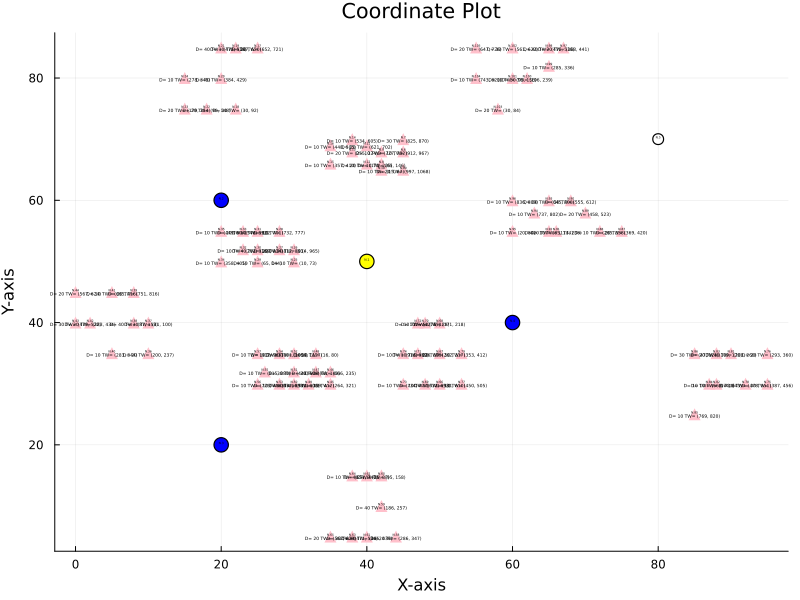

In [4]:
#===========SET==============================================================#
x_coor_customers, y_coor_customers, x_coor_depot, y_coor_depot, demands, time_windows, zeta = readFile()
# Number of customers
nc = length(x_coor_customers)
# Coordinate x (Parking node)
x_coor_parkings = [20,20,60,80]
# Coordinate y (Parking node)
y_coor_parkings = [60,20,40,70]

# Number of parking places
np = length(x_coor_parkings)
P = 2 : np+1 #Set of parking place
C = np+2 : np+nc+1 #Set of customers
A1 = 1 : 1+np #Set of FE arcs
A2 = 2 : 1+np+nc #Set of SE arcs
V1 = 1:1 #Set of FEV
V2 = 1:1 #Set of SEV
N = 1:np+nc+1 #Set of nodes

#===========PARAMETER========================================================#
Q0 = 100 #Capacity of FEV
Q1 = 60 #Capacity of MM
Q2 = 20 #Capacity of SEV
M = 10000
PI = [1,1,1,0] #Initial parking indicator
eta1 = 2
eta2 = 1

x_coor = vcat(x_coor_depot, x_coor_parkings, x_coor_customers)
y_coor = vcat(y_coor_depot, y_coor_parkings, y_coor_customers)

node_labels = [string("N.", i) for i in N]
demand_labels = [string(demands[i-1-np]," ",time_windows[i-1-np]) for i in C]


displayMap()


In [5]:
# Disatance matrix
distances = calculate_distance_matrix(x_coor,y_coor,nc)
Vitesse1 = 2
Vitesse2 = 1
println(" ")
TT1 = (distances / Vitesse1)
TT2 = (distances / Vitesse2)

100.00  22.36  36.06  22.36  44.72  100.00  100.00  100.00  100.00  100.00  100.00  100.00  100.00  100.00  100.00  100.00  100.00  100.00  100.00  100.00  100.00  100.00  100.00  100.00  100.00  100.00  100.00  100.00  100.00  100.00  100.00  100.00  100.00  100.00  100.00  100.00  100.00  100.00  100.00  100.00  100.00  100.00  100.00  100.00  100.00  100.00  100.00  100.00  100.00  100.00  100.00  100.00  100.00  100.00  100.00  100.00  100.00  100.00  100.00  100.00  100.00  100.00  100.00  100.00  100.00  100.00  100.00  100.00  100.00  100.00  100.00  100.00  100.00  100.00  100.00  100.00  100.00  100.00  100.00  100.00  100.00  100.00  100.00  100.00  100.00  100.00  100.00  100.00  100.00  100.00  100.00  100.00  100.00  100.00  100.00  100.00  100.00  100.00  100.00  100.00  100.00  100.00  100.00  100.00  100.00  
22.36  100.00  40.00  44.72  60.83  26.25  26.93  22.80  23.41  22.56  21.93  20.88  19.70  20.59  16.16  17.49  25.50  15.13  25.08  20.00  25.00  15.13  15.81  2

100.00  19.70  51.26  35.61  42.05  7.00   7.28   4.47   4.00   5.00   2.24   2.83   100.00  2.00   3.61   3.16   21.40  17.46  23.35  21.63  24.76  21.19  24.04  25.94  19.70  17.89  18.87  16.40  22.20  20.62  18.38  21.93  19.85  25.46  22.20  43.28  39.60  41.04  37.80  46.67  40.22  45.61  47.20  44.42  38.12  36.12  36.35  33.38  38.47  38.83  36.88  33.96  39.29  34.48  37.95  40.16  35.47  63.29  58.14  53.15  63.03  53.04  63.00  53.00  63.07  39.85  35.11  30.46  39.29  29.73  34.21  29.41  38.64  33.73  68.51  65.86  40.85  66.03  36.25  7.62   61.59  62.80  59.91  62.01  63.70  57.43  39.22  36.40  33.53  31.05  30.87  29.97  28.16  26.93  25.55  23.41  33.62  31.91  30.41  26.83  25.06  27.80  21.19  20.81  24.04  
100.00  20.59  53.14  37.20  42.00  7.28   7.00   5.66   4.47   6.40   2.24   4.47   2.00   100.00  5.00   3.16   19.85  16.76  21.93  20.59  23.43  20.62  23.54  25.08  21.54  19.70  20.59  18.03  23.85  22.20  19.85  23.43  21.21  26.91  23.43  44.82  41.04  4

100.00  12.81  33.53  32.31  53.14  21.93  23.43  18.44  20.00  17.69  19.72  17.20  17.89  19.70  14.87  17.72  33.38  24.35  33.96  29.73  34.48  25.94  27.46  31.76  2.00   100.00  2.00   3.61   5.39   5.00   5.83   7.00   7.62   10.20  10.44  26.25  23.32  25.06  23.09  30.23  25.96  30.46  32.31  30.81  22.56  20.62  20.22  17.26  22.09  22.00  20.00  17.00  22.09  17.12  20.40  22.56  17.72  49.04  43.68  38.90  48.05  38.33  47.68  37.85  47.27  29.73  26.25  23.32  28.43  21.63  24.04  20.81  26.63  22.67  68.62  67.19  31.83  65.79  28.60  19.85  62.36  62.03  60.44  61.10  61.27  57.57  45.10  42.11  40.45  38.83  36.12  35.13  35.90  33.54  30.15  31.05  49.58  48.10  46.10  42.52  41.04  44.60  36.24  37.54  41.40  
100.00  11.31  32.98  34.18  55.03  23.35  24.76  19.80  21.26  19.10  20.81  18.44  18.87  20.59  15.65  18.38  33.14  23.77  33.54  29.12  33.96  25.08  26.42  30.87  2.83   2.00   100.00  3.00   3.61   3.00   4.24   5.00   5.83   8.25   8.54   24.76  21.63  2

100.00  30.87  17.69  28.16  60.44  37.95  39.85  35.17  37.11  34.21  37.66  34.71  36.35  38.33  34.06  37.05  53.60  44.38  54.13  49.73  54.57  45.54  46.62  51.26  18.25  20.22  20.62  23.54  19.70  21.54  24.35  22.36  25.08  22.20  26.42  23.19  24.35  26.25  28.18  28.16  30.87  32.02  33.96  35.47  2.83   2.00   100.00  3.00   2.24   3.61   3.00   4.24   5.39   5.83   7.00   8.25   8.54   29.15  23.77  19.24  27.89  18.38  27.46  17.72  27.07  17.12  17.26  18.79  15.13  17.00  14.32  16.12  12.17  12.37  62.03  62.07  20.10  59.03  20.22  35.11  57.08  55.04  55.08  54.04  52.47  52.09  47.89  45.28  45.22  44.82  40.22  39.41  42.52  39.70  35.47  38.90  62.97  61.91  59.36  56.08  55.07  59.48  49.74  52.80  57.38  
100.00  28.18  19.85  27.46  58.60  35.11  37.00  32.28  34.21  31.32  34.71  31.78  33.38  35.36  31.06  34.06  50.64  41.48  51.20  46.84  51.66  42.72  43.86  48.47  15.30  17.26  17.72  20.62  17.00  18.79  21.54  19.72  22.36  19.85  23.85  23.00  23.54  25

100.00  49.24  20.62  32.02  68.01  53.24  55.23  51.04  53.04  50.04  54.00  51.00  53.04  55.04  51.24  54.23  71.59  62.64  72.28  68.01  72.80  63.91  65.00  69.64  36.40  38.33  38.90  41.76  38.08  39.92  42.72  40.72  43.46  40.31  44.72  36.06  39.05  40.61  43.86  40.31  46.10  45.49  47.17  50.00  15.81  17.72  18.38  21.19  17.00  18.03  19.72  22.36  19.21  23.32  22.02  21.21  25.00  10.77  5.39   2.00   10.00  100.00  10.20  2.00   11.18  18.03  22.36  26.93  17.00  26.25  21.19  25.96  15.81  20.62  57.01  58.52  19.85  54.12  23.85  50.25  53.85  50.29  52.00  49.34  46.10  49.24  53.15  51.22  52.43  53.00  47.71  47.17  51.48  48.76  44.72  49.24  75.03  74.33  71.51  68.62  68.01  72.80  62.64  66.71  71.59  
100.00  57.87  23.43  41.34  77.39  63.39  65.38  61.13  63.13  60.13  64.03  61.03  63.00  65.00  61.07  64.07  81.05  71.81  81.58  77.13  82.00  72.80  73.68  78.45  45.71  47.68  48.05  50.99  46.84  48.76  51.66  49.34  52.20  48.47  53.14  41.04  44.82  46

100.00  80.78  75.66  36.40  42.72  62.80  64.03  64.07  65.22  63.51  67.42  65.73  68.51  69.63  69.97  71.56  89.02  85.76  91.40  90.14  93.01  89.19  91.79  94.34  68.01  68.62  70.52  71.51  72.80  73.38  74.33  75.29  76.22  77.62  79.06  85.15  85.59  87.57  88.28  90.14  91.24  93.54  95.52  96.18  60.00  60.03  62.03  62.20  63.00  65.00  65.03  65.19  67.00  67.19  69.03  70.00  70.18  56.80  56.65  55.08  60.42  57.01  62.24  58.94  65.00  45.00  45.28  46.10  47.00  48.05  48.26  49.03  50.00  50.25  100.00  5.00   42.00  3.00   42.30  61.03  7.07   7.00   8.60   8.00   11.18  11.18  32.02  33.97  37.54  40.36  38.29  39.05  42.43  42.52  43.01  46.10  61.72  62.65  60.03  59.91  61.03  65.19  58.26  64.03  68.01  
100.00  79.06  76.49  35.36  38.08  59.91  61.03  61.40  62.43  60.90  64.66  63.13  65.86  66.89  67.54  68.96  86.02  83.24  88.48  87.46  90.14  86.77  89.44  91.79  66.71  67.19  69.12  69.92  71.59  72.03  72.80  73.98  74.73  76.49  77.62  85.00  85.15  87

100.00  55.23  65.19  21.21  15.81  32.70  33.54  34.79  35.47  34.48  37.70  36.69  39.22  39.92  41.48  42.38  58.31  56.65  60.90  60.42  62.65  60.41  63.25  65.00  45.28  45.10  47.10  47.00  50.25  50.09  50.00  52.09  52.00  55.23  55.00  68.01  66.71  68.66  67.74  72.80  70.71  74.53  76.49  75.66  47.17  46.14  47.89  46.52  49.74  51.48  50.54  49.24  53.24  51.08  54.13  55.90  53.85  58.83  55.80  51.86  61.03  53.15  62.20  54.49  64.03  35.36  32.02  29.15  36.80  30.89  34.41  31.76  39.05  36.06  32.02  28.28  33.30  30.23  29.73  31.62  25.00  28.18  23.85  27.73  31.62  22.36  100.00  3.00   5.83   8.60   9.00   10.00  11.18  12.37  15.00  15.81  31.05  31.62  28.79  28.18  29.15  33.54  26.25  32.02  36.06  
100.00  52.24  62.68  19.21  17.00  29.97  30.89  31.95  32.70  31.62  34.93  33.84  36.40  37.16  38.60  39.56  55.76  53.85  58.31  57.70  60.03  57.58  60.41  62.24  42.30  42.11  44.10  44.00  47.27  47.10  47.00  49.09  49.00  52.24  52.00  65.15  63.79  65

100.00  51.48  79.06  45.28  21.21  26.25  25.00  29.83  28.60  30.48  29.68  31.40  31.91  30.89  35.51  34.00  40.00  44.15  43.00  45.28  45.00  48.05  50.99  50.25  49.50  48.10  49.58  47.63  53.15  51.86  50.00  53.41  51.61  57.01  54.08  74.33  71.06  72.62  69.63  78.10  72.11  77.42  79.06  76.32  62.65  60.90  61.91  59.36  64.14  65.19  63.51  61.03  66.29  62.20  65.80  68.01  64.03  82.71  78.45  73.68  83.82  74.33  84.43  75.03  85.44  57.01  52.20  47.43  57.57  48.10  53.14  48.47  58.52  53.85  62.65  58.31  56.29  61.27  51.42  28.28  55.90  59.62  55.04  59.24  63.25  53.85  31.62  30.81  27.46  25.18  30.02  30.00  25.00  27.07  30.41  25.50  2.00   100.00  3.00   5.83   7.07   5.00   12.21  11.18  10.00  
100.00  50.09  76.61  42.30  19.21  24.41  23.32  28.02  26.93  28.60  28.18  29.68  30.41  29.55  34.00  32.70  40.11  43.57  43.10  45.04  45.10  47.52  50.49  50.04  47.42  46.10  47.63  45.80  51.22  50.00  48.26  51.61  49.93  55.22  52.48  72.35  69.20  70

105×105 Matrix{Float64}:
 100.0      22.3607   36.0555   22.3607  …  100.0      100.0      100.0
  22.3607  100.0      40.0      44.7214      40.8534    40.3113    43.0116
  36.0555   40.0     100.0      44.7214      66.8506    69.4622    73.8241
  22.3607   44.7214   44.7214  100.0         35.0571    40.3113    45.2769
  44.7214   60.8276   78.1025   36.0555      22.561     26.9258    29.1548
 100.0      26.2488   54.1202   31.7648  …   14.7648    15.6205    19.7231
 100.0      26.9258   55.9017   33.541       13.9284    14.1421    18.0278
 100.0      22.8035   50.9902   31.6228      18.3576    19.105     23.0217
 100.0      23.4094   52.8015   33.2866      17.4642    17.6918    21.4009
 100.0      22.561    50.0899   30.8058      18.868     19.8494    23.8537
 100.0      21.9317   52.9245   35.2278  …   18.9737    18.6011    21.9317
 100.0      20.8806   50.1597   32.8024      20.1246    20.5183    24.2074
 100.0      19.6977   51.264    35.609       21.1896    20.8087    24.0416
   

In [6]:
model=Model(CPLEX.Optimizer)

# Decision variable
@variable(model, x[A1,A1], Bin)#Arc(x,y) traversed by FEV
@variable(model, y[A1,A1], Bin)#Arc(x,y) traversed by MM
for i in 1:np+1
    @constraint(model, x[i, i] == 0)
    @constraint(model, y[i, i] == 0)
end

@variable(model, t[A2]>=0, Int) #Arrival time

@variable(model, w[P]>=0, Int) #Amount of freight transported from the depot to parking node

@variable(model, z[A2,A2], Bin)#Arc(x,y) traversed by SEV
for i in A2
    @constraint(model, z[i,i] == 0)
    for j in A2
        if i in P && j in P
            @constraint(model, z[i,j]==0)
        end
    end
end

@variable(model, f[A2,A2]>=0,Int) #Load of SEV
#=================================================================================================#
@objective(model, Min,
    sum(distances[i, j] * x[i, j] for i in A1, j in A1 if i != j) +
    sum(distances[i, j] * y[i, j] for i in A1, j in A1 if i != j) +
    sum(distances[i, j] * z[i, j] for i in A2, j in A2 if i != j))
#=================================================================================================#

#13 #14 #15
#Flow consercvation at parking and customerfor SEV
@constraint(model, [i in A2], sum(z[i,j] for j in A2)==sum(z[j,i] for j in A2))
@constraint(model, [p in P], sum(z[p,j] for j in A2)<=1)
@constraint(model, [i in C], sum(z[i,j] for j in A2) ==1)

# #16
# #Customer demand met
# @constraint(model, [i in C], sum(f[j,i] for j in A2)-sum(f[i,j] for j in A2) == demands[i-1-np])

# #17
# #Connection and capacity limit for SEV
# @constraint(model, [i in A2, j in A2], f[i,j]<=Q2*z[i,j])

# #11
# #Link 1st and 2nd
# @constraint(model, [p in P], w[p]== sum(f[p,j] for j in A2 if p !=j))

# #12
# #Capacity limit for MM and connection of FEV
# @constraint(model, [p in P], w[p]<=Q1*sum(x[i,p] for i in A1))

# #1 #2
# #Flow conservation at parking for FEV
# @constraint(model, [i in P], sum(x[j,i] for j in A1 if i != j) == sum(x[i,j] for j in A1 if i != j))
# @constraint(model, [i in P], sum(x[i,j] for j in A1 if i != j) <= 1)

# #5 #6
# #Flow conservation at depot
# @constraint(model, sum(x[1,j] for j in A1 if j !=1)==1)
# @constraint(model, sum(x[j,1] for j in A1 if j !=1)==1)

# #7
# #Capacity limit for FEV
# @constraint(model, sum(w[p] for p in P)<=Q0)

# #3
# #Flow conservation of MM
# @constraint(model, [i in P], sum(y[i,j] for j in A1 if i != j) + sum(y[j,i] for j in A1 if i != j)<=1)

# #4
# #Limit for mobile microhub
# @constraint(model, [i in A1, j in A1], y[i,j] <= x[i,j])

# #15 16
# #Flow conservation at customer node
# @constraint(model, [i in C], sum(z[j,i] for j in A2)==1)
# @constraint(model, [i in C], sum(z[i,j] for j in A2)==1)

# #18
# #Capacity limit for SEV
# @constraint(model, [p in P, j in A2], f[p,j]<= Q2*z[p,j])

# #12 *
# #Can't distribute from a site without MM
# @constraint(model, [p in P], w[p]<=Q1*(sum(y[i,p] for i in A1)+PI[p]))


# #10
# #If MM leaves a site, the freight to the site should be zero, otw could be positive
# @constraint(model, [p in P], w[p]<=Q1*(1-sum(y[p,j] for j in A1)))

# #8
# #Can't tow a MM from parking without MM
# @constraint(model, [i in A1], sum(y[i,j] for j in A1)<= PI[i])

# #9
# #Initial MM must be visited
# @constraint(model, [j in A1], sum(y[i,j] for i in A1)<=1-PI[j])

# #=================================================================================================#

# #* Time constraint for SEV from parking
# @constraint(model, [i in P, j in C], t[j] >= t[i] + TT2[i,j] * z[i,j])
# #* Time constraint for FEV from depot
# @constraint(model, [i in P], t[i] >= TT1[1,i] * x[1,i])

# #23
# #Within Time Window
# @constraint(model, [i in C], TW[i-1-np][1] <= t[i])
# @constraint(model, [i in C], TW[i-1-np][2] >= t[i])

# #19
# #Planning horizon for FEV
# # @constraint(model, sum(x[i,j] * TT1[i,j] for i in A1 for j in A1) + eta1 * sum(x[i,p] * PI[p] for i in A1 for p in P)<= zeta )

# #20
# #*
# #Planning horiozn for SEV
# @constraint(model, [i in C, j in P],  t[i] + TT2[i,j] + eta2 <= zeta + M * (1-z[i,j]) )

# # #21
# # #Time constraint for FEV and MTZ
# @constraint(model, [i in P, j in P], t[i]+(1-x[i,j])+TT1[i,j]*x[i,j] <= t[j]+M * (1 - x[i,j]))

# # #22
# # #Time constraint for SEV and MTZ
# @constraint(model, [i in C, j in C], t[i]+(1-z[i,j])+TT2[i,j]*z[i,j] <= t[j]+M * (1 - z[i,j]))

1-dimensional DenseAxisArray{ConstraintRef{Model, MathOptInterface.ConstraintIndex{MathOptInterface.ScalarAffineFunction{Float64}, MathOptInterface.EqualTo{Float64}}, ScalarShape},1,...} with index sets:
    Dimension 1, 6:105
And data, a 100-element Vector{ConstraintRef{Model, MathOptInterface.ConstraintIndex{MathOptInterface.ScalarAffineFunction{Float64}, MathOptInterface.EqualTo{Float64}}, ScalarShape}}:
 z[6,2] + z[6,3] + z[6,4] + z[6,5] + z[6,6] + z[6,7] + z[6,8] + z[6,9] + z[6,10] + z[6,11] + z[6,12] + z[6,13] + z[6,14] + z[6,15] + z[6,16] + z[6,17] + z[6,18] + z[6,19] + z[6,20] + z[6,21] + z[6,22] + z[6,23] + z[6,24] + z[6,25] + z[6,26] + z[6,27] + z[6,28] + z[6,29] + z[6,30] + z[6,31] + [[...44 terms omitted...]] + z[6,76] + z[6,77] + z[6,78] + z[6,79] + z[6,80] + z[6,81] + z[6,82] + z[6,83] + z[6,84] + z[6,85] + z[6,86] + z[6,87] + z[6,88] + z[6,89] + z[6,90] + z[6,91] + z[6,92] + z[6,93] + z[6,94] + z[6,95] + z[6,96] + z[6,97] + z[6,98] + z[6,99] + z[6,100] + z[6,101] + z[6,1

In [7]:
# Solve the model
optimize!(model)

# Check solution status and display results
if termination_status(model) == MOI.OPTIMAL
    println("Total distance traveled: ", objective_value(model))
    for i in A1
        for j in A1
            if value(x[i,j])==1 print("  x[",i,",",j,"]=",value(x[i,j])) end
        end
    end
    println(" ")
    for i in A1
        for j in A1
            if value(y[i,j])==1 print("  y[",i,",",j,"]=",value(y[i,j])) end
        end
    end
    println(" ")
    for i in A2 print("  t[",i,"]=",value(t[i])) end
    println(" ")
#     for r in V2
        for i in A2
            for j in A2
                if value(z[i,j])==1 print("  z[",i,",",j,"]=",value(z[i,j])) end
            end
            println(" ")
        end
#     end
    println(" ")
    for i in P
        print("  w[",i,"]=",value(w[i]))
    end
    println(" ")
    for i in A2
        for j in A2
            if value(f[i,j]) != 0 print("  f[",i,",",j,"]=",value(f[i,j])) end
        end
    end
else
    println("No feasible solution found.")
end

Version identifier: 22.1.1.0 | 2022-11-27 | 9160aff4d
Tried aggregator 1 time.
MIP Presolve eliminated 130 rows and 11090 columns.
MIP Presolve modified 10300 coefficients.
Reduced MIP has 208 rows, 10700 columns, and 21800 nonzeros.
Reduced MIP has 10700 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.02 sec. (28.06 ticks)
Found incumbent of value 4049.573963 after 0.05 sec. (59.66 ticks)
Tried aggregator 1 time.
Detecting symmetries...
Reduced MIP has 208 rows, 10700 columns, and 21800 nonzeros.
Reduced MIP has 10700 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.02 sec. (20.68 ticks)
Probing time = 0.02 sec. (5.49 ticks)
Clique table members: 204.
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 8 threads.
Root relaxation solution time = 0.02 sec. (5.38 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer   

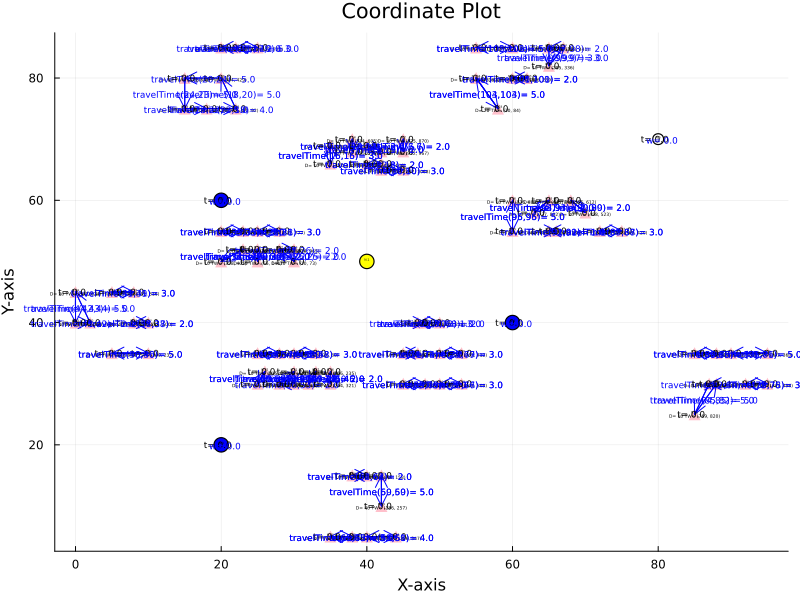

In [8]:
displayMap()
if termination_status(model) == MOI.OPTIMAL
    time_labels = [string("t= ", value(t[i])) for i in A2]
    flow_labels = [string("f(",i,",",j,")= ", value(f[i,j])) for i in A2 for j in A2]
    loan_labels = [string("w= ", value(w[i])) for i in P]
    distances_labels = [string("dist(",i,",",j,")= ", floor(value(distances[i,j]))) for i in N for j in N]
    speed1_labels = [string("travelTime(",i,",",j,")= ", floor(value(TT1[i,j]))) for i in N for j in N]
    speed2_labels = [string("travelTime(",i,",",j,")= ", floor(value(TT2[i,j]))) for i in N for j in N]
    light_green = RGBA(0.5, 1.0, 0.5, 1.0)

    # Add FE arcs between the locations if they are traversed
    for i in A1
        for j in A1         
            if value(y[i, j]) == 1
                plot!([x_coor[i], x_coor[j]], [y_coor[i], y_coor[j]], 
                      line=:arrow,color = light_green, label = "", linealpha=4, lw=4)
            end
            if value(x[i, j]) == 1
                plot!([x_coor[i], x_coor[j]], [y_coor[i], y_coor[j]], 
                      line=:arrow,color = :red, label = "")
                mid_x = (x_coor[i] + x_coor[j]) / 2
                mid_y = (y_coor[i] + y_coor[j]) / 2 +0.2
                annotate!(mid_x, mid_y, text(speed1_labels[(i-1)*(np+nc+1)+j],6 ,:blue))
            end
        end
    end
    # Add SE arcs between the locations if they are traversed
    for i in A2
        annotate!(x_coor[i]-0.5, y_coor[i], text(time_labels[i-1], :center, 6))
        for j in A2
            if value(z[i, j]) == 1
                plot!([x_coor[i], x_coor[j]], [y_coor[i], y_coor[j]], 
                    line=:arrow,color = :blue, label = "")
                mid_x = (x_coor[i] + x_coor[j]) / 2
                mid_y = (y_coor[i] + y_coor[j]) / 2 - 0.2
                annotate!(mid_x, mid_y, text(speed2_labels[(i-1)*(np+nc+1)+j],6 ,:blue))
                if value(f[i,j]) != 0
                    mid_x = (x_coor[i] + x_coor[j]) / 2
                    mid_y = (y_coor[i] + y_coor[j]) / 2 +0.2
                    annotate!(mid_x, mid_y, text(flow_labels[(i-2)*(np+nc)+j-1],6 ,:blue))
                end
            end
        end
    end

    for p in P
        annotate!(x_coor[p]+0.5,y_coor[p]-0.2, text(loan_labels[p-1],6 ,:blue))
    end
    
end
plot!()